In [7]:
import warnings
import itertools
import pandas as pd

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader.data as web

import seaborn as sns
from pylab import rcParams
from pandas import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.arima_model import ARIMA 
from sklearn.metrics import mean_squared_error


# Download Data from yahoo

In [8]:

startDate = datetime(2010,1,4)
endDate = datetime(2020,4,1)

df=web.DataReader('MSFT', 'yahoo', startDate, endDate)

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,31.100000,30.590000,30.620001,30.950001,38409100.0,24.294369
2010-01-05,31.100000,30.639999,30.850000,30.959999,49749600.0,24.302216
2010-01-06,31.080000,30.520000,30.879999,30.770000,58182400.0,24.153070
2010-01-07,30.700001,30.190001,30.629999,30.450001,50559700.0,23.901886
2010-01-08,30.879999,30.240000,30.280001,30.660000,51197400.0,24.066734


C:\Users\diksh\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


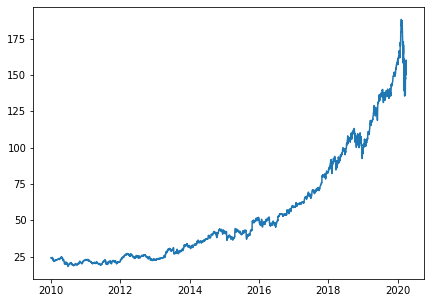

In [9]:
rcParams['figure.figsize'] = 7, 5
plt.plot(df["Adj Close"], label = "Adj Close")

# Data Pre-Procassing

In [10]:
data = df

#make the data column as index
data.index = pd.to_datetime(data.index)

In [11]:
#function to convert the columns to numeric
def convert_to_numeric(dataframe):
    for col in dataframe:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    return dataframe

#function to perform interpolation
def interpolate(dataframe):
    features = list(dataframe)
    for feature in features:
        dataframe[feature] = dataframe[feature].interpolate()
    return dataframe

def remove_missing_values(data):
    data = data.dropna(axis=0)
    return data

#function to add rows for missing dates
def add_missing_dates(dataframe, start, end):
    idx = pd.date_range(start, end)
    dataframe.index = pd.DatetimeIndex(dataframe.index)
    dataframe = dataframe.reindex(idx, fill_value='np.nan')
    return dataframe

data = add_missing_dates(data, startDate, endDate)
data = convert_to_numeric(data)
data = interpolate(data)


In [12]:
#Delete the columns which are not used
#We will be using only the Close values
data = data.fillna(data.bfill())
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
data.drop(cols, axis=1, inplace=True)

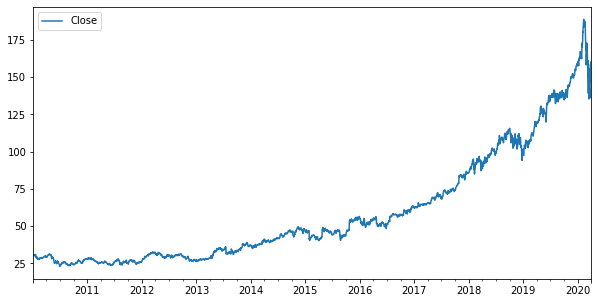

In [13]:
data.plot(figsize=(10, 5))
plt.show()

# Visualize data

Visualize data by decomposing time series into Trend Seasonality and Residue

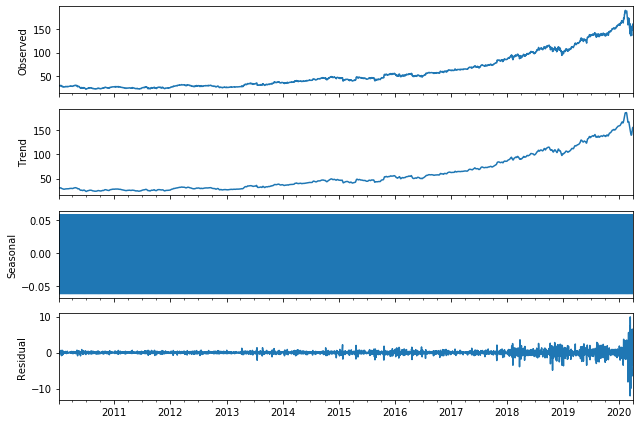

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 9, 6

decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

There is an upward trend to the data but seasonal effect in insignificant. 
The Residuals  component is left after other components have been calculated 
and removed from time series data. It is randomly, identically and independently distributed

# Check if time series is stationary

The time series is not stationary since it had trend. Find and plot the rolling mean and rolling standard deviation for visualizing if the data is stationary or not. For a more accurate assessment there is the Augmented Dickey-Fuller (ADF) test. ADF test result provides test statistic and P value. P value >= 0.05 means the data is not stationary

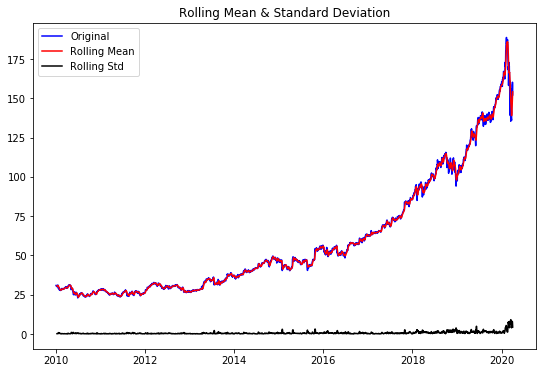

Results of Dickey-Fuller Test:
Test Statistic                    1.672162
p-value                           0.998059
#Lags Used                       30.000000
Number of Observations Used    3710.000000
Critical Value (1%)              -3.432114
Critical Value (5%)              -2.862319
Critical Value (10%)             -2.567185
dtype: float64


In [15]:
from statsmodels.tsa.stattools import adfuller

def isSeriesStationary(data):
  #Calculate rolling statistics
  rolling_mean = data.rolling(window=8, center = False).mean()
  rolling_std = data.rolling(window=8, center = False).std()

  #Perform the Dickey Fuller Test
  df_test = adfuller(data)

  orig = plt.plot(data, color='blue',label='Original')
  mean = plt.plot(rolling_mean,color='red', label='Rolling Mean')
  std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  print ('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in df_test[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

isSeriesStationary(data.Close)

The results of ADF test give p>0.05 and also the plot shows there is a changing mean or variation in the data. Hence the time series is not stationary.

# Make Time series Stationary

To make the data stationary, we take a first difference of the data and check if data is stationary. If data is not stationary, we perform second differencing. The number of times the differencing was performed to make the series stationary is the value of the ‘d’ parameter for our ARIMA model.

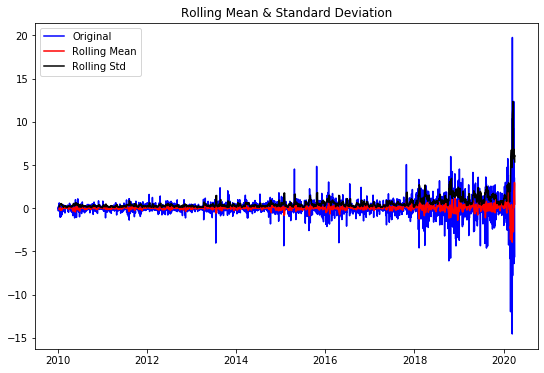

Results of Dickey-Fuller Test:
Test Statistic                -1.208628e+01
p-value                        2.173862e-22
#Lags Used                     3.000000e+01
Number of Observations Used    3.709000e+03
Critical Value (1%)           -3.432114e+00
Critical Value (5%)           -2.862320e+00
Critical Value (10%)          -2.567185e+00
dtype: float64


In [16]:
#Take First difference
data_diff=data.Close-data.Close.shift()
data_diff.dropna(inplace = True)
isSeriesStationary(data_diff)

#Take Second difference
#data_diff = data_diff - data_diff.shift()
#data_diff.dropna(inplace = True)
#isSeriesStationary(data_diff)

The data becomes stationary after differencing. Hence the value of 'd' parameter is 1.

# Plot ACF and PACF and the the parameters p and q

The next step is to determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs

C:\Users\diksh\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


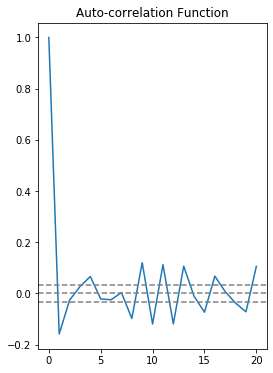

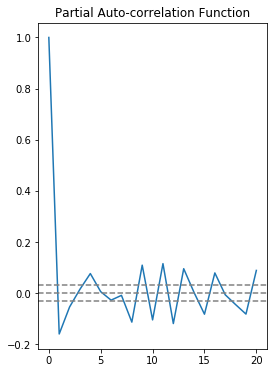

<Figure size 648x432 with 0 Axes>

In [17]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(data_diff, nlags=20)
lag_pacf = pacf(data_diff, nlags=20, method='ols')

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_diff)),linestyle='--',color='gray')
plt.title('Auto-correlation Function')
plt.show()

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_diff)),linestyle='--',color='gray')
plt.title('Partial Auto-correlation Function')
plt.show()
plt.tight_layout()

In the above plots for ACF and PACF, the grey lines represent the confidence level. If we look at ACF plot carefully, we will see that the upper confidence level line has been crossed at lag1. Therefore, the order of AR would be 1 and p=1. Similarly, in the plot of PACF, the the upper confidence level line has been crossed at lag1. Therefore, the order of MA would be 1 and q=1.

In [18]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

# Build Model and Predict

In [22]:
#BUILD MODEL

#Split data
train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

C:\Users\diksh\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing Mean Squared Error: 11.285
Symmetric mean absolute percentage error: 12.071


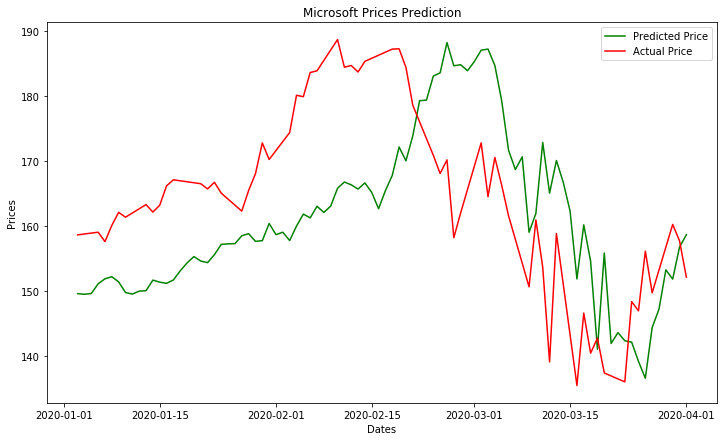

In [23]:
test_data=data[-90:]
predictions=predictions[-90:]

plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', label='Predicted Price')
plt.plot(test_data.index, test_data.Close.values, color='red', label='Actual Price')
plt.title('Microsoft Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()




# Model Tuning 

In [24]:
p_values = range(0,2)
d_values = range(0, 2)
q_values = range(0, 2)

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    
warnings.filterwarnings("ignore")
evaluate_models(df.Open.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=3922.952
ARIMA(0, 0, 1) MSE=1021.804
ARIMA(0, 1, 0) MSE=3.724
ARIMA(0, 1, 1) MSE=3.694
ARIMA(1, 0, 0) MSE=3.731
ARIMA(1, 1, 0) MSE=3.701
Best ARIMA(0, 1, 1) MSE=3.694
